### OpenPose 연습
---

#### 방법 1. MPI
- 출력 관절 16

In [25]:
import cv2

# MPII에서 각 파트 번호, 선으로 연결될 POSE_PAIRS
BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                "Background": 15 }

POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
    
# 각 파일 path
protoFile = 'mpii/pose_deploy_linevec_faster_4_stages.prototxt'
weightsFile = 'mpii/pose_iter_160000.caffemodel'
 
# 위의 path에 있는 network 불러오기
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# 이미지 읽어오기
image = cv2.imread('[apt]attend_1140A_114.jpg')

# frame.shape = 불러온 이미지에서 height, width, color 받아옴
imageHeight, imageWidth, _ = image.shape
 
# network에 넣기위해 전처리
inpBlob = cv2.dnn.blobFromImage(image, 1.0 / 255, (imageWidth, imageHeight), (0, 0, 0), swapRB=False, crop=False)
 
# network에 넣어주기
net.setInput(inpBlob)

# 결과 받아오기
output = net.forward()

# output.shape[0] = 이미지 ID, [1] = 출력 맵의 높이, [2] = 너비
H = output.shape[2]
W = output.shape[3]
print("이미지 ID : ", len(output[0]), ", H : ", output.shape[2], ", W : ",output.shape[3]) # 이미지 ID

# 키포인트 검출시 이미지에 그려줌
points = []
for i in range(0,15):
    # 해당 신체부위 신뢰도 얻음.
    probMap = output[0, i, :, :]
    print(probMap)
 
    # global 최대값 찾기
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

    # 원래 이미지에 맞게 점 위치 변경
    x = (imageWidth * point[0]) / W
    y = (imageHeight * point[1]) / H

    # 키포인트 검출한 결과가 0.1보다 크면(검출한곳이 위 BODY_PARTS랑 맞는 부위면) points에 추가, 검출했는데 부위가 없으면 None으로    
    if prob > 0.1 :    
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)       # circle(그릴곳, 원의 중심, 반지름, 색)
        cv2.putText(image, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, lineType=cv2.LINE_AA)
        points.append((int(x), int(y)))
    else :
        points.append(None)

# cv2.imshow("Output-Keypoints",image)
# cv2.waitKey(0)

# 이미지 복사
imageCopy = image

# 각 POSE_PAIRS별로 선 그어줌 (머리 - 목, 목 - 왼쪽어깨, ...)
for pair in POSE_PAIRS:
    partA = pair[0]             # Head
    partA = BODY_PARTS[partA]   # 0
    partB = pair[1]             # Neck
    partB = BODY_PARTS[partB]   # 1
    
    #print(partA," 와 ", partB, " 연결\n")
    if points[partA] and points[partB]:
        cv2.line(imageCopy, points[partA], points[partB], (0, 255, 0), 2)

cv2.imshow("Output-Keypoints",imageCopy)
cv2.waitKey(0)
cv2.destroyAllWindows()

이미지 ID :  44 , H :  135 , W :  240
[[0.00045575 0.00045304 0.0004107  ... 0.0003746  0.0003948  0.00041761]
 [0.0004315  0.00041241 0.00038195 ... 0.00037461 0.00038853 0.00041257]
 [0.0004124  0.00038842 0.00038935 ... 0.00039333 0.00039946 0.00039524]
 ...
 [0.0004631  0.00047512 0.00047436 ... 0.00049198 0.00052035 0.00053336]
 [0.00046537 0.00048905 0.00050299 ... 0.00053432 0.00055375 0.00056845]
 [0.00053075 0.00049264 0.0005071  ... 0.00055358 0.00057655 0.00059797]]
[[0.00085555 0.00086785 0.00078796 ... 0.00070105 0.00074968 0.0007834 ]
 [0.00080377 0.0007813  0.00071874 ... 0.00070106 0.00073459 0.00078627]
 [0.00076818 0.00073432 0.00073655 ... 0.00074615 0.0007609  0.00075074]
 ...
 [0.00090029 0.00091443 0.00091838 ... 0.0009841  0.00105995 0.00105881]
 [0.0009171  0.00094248 0.00096215 ... 0.00108138 0.00111785 0.0011029 ]
 [0.00104332 0.00094629 0.00096799 ... 0.00111235 0.00114264 0.0011421 ]]
[[0.0004042  0.00039717 0.00026979 ... 0.00017407 0.00022763 0.00030266]
 [0.

In [26]:
# 웹캠

import cv2
from pathlib import Path

# MPII에서 각 파트 번호, 선으로 연결될 POSE_PAIRS
BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                "Background": 15 }

POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
    
# 각 파일 path
#BASE_DIR=Path(__file__).resolve().parent
protoFile = 'mpii/pose_deploy_linevec_faster_4_stages.prototxt'
weightsFile = 'mpii/pose_iter_160000.caffemodel'
 
# 위의 path에 있는 network 모델 불러오기
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

#쿠다 사용 안하면 밑에 이미지 크기를 줄이는게 나을 것이다
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA) #벡엔드로 쿠다를 사용하여 속도향상을 꾀한다
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA) # 쿠다 디바이스에 계산 요청


###카메라랑 연결...?
capture = cv2.VideoCapture(0) #카메라 정보 받아옴
# capture.set(cv2.CAP_PROP_FRAME_WIDTH, 640) #카메라 속성 설정
# capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) # width:너비, height: 높이

inputWidth=320;
inputHeight=240;
inputScale=1.0/255;

 
#반복문을 통해 카메라에서 프레임을 지속적으로 받아옴
while cv2.waitKey(1) <0:  #아무 키나 누르면 끝난다.
    #웹캠으로부터 영상 가져옴
    hasFrame, frame = capture.read()  
    
    #영상이 커서 느리면 사이즈를 줄이자
    #frame=cv2.resize(frame,dsize=(320,240),interpolation=cv2.INTER_AREA)
    
    #웹캠으로부터 영상을 가져올 수 없으면 웹캠 중지
    if not hasFrame:
        cv2.waitKey()
        break
    
    # 
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    inpBlob = cv2.dnn.blobFromImage(frame, inputScale, (inputWidth, inputHeight), (0, 0, 0), swapRB=False, crop=False)
    
    imgb=cv2.dnn.imagesFromBlob(inpBlob)
    #cv2.imshow("motion",(imgb[0]*255.0).astype(np.uint8))
    
    # network에 넣어주기
    net.setInput(inpBlob)

    # 결과 받아오기
    output = net.forward()

    # 키포인트 검출시 이미지에 그려줌
    points = []
    for i in range(0,15):
        # 해당 신체부위 신뢰도 얻음.
        probMap = output[0, i, :, :]
    
        # global 최대값 찾기
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # 원래 이미지에 맞게 점 위치 변경
        x = (frameWidth * point[0]) / output.shape[3]
        y = (frameHeight * point[1]) / output.shape[2]

        # 키포인트 검출한 결과가 0.1보다 크면(검출한곳이 위 BODY_PARTS랑 맞는 부위면) points에 추가, 검출했는데 부위가 없으면 None으로    
        if prob > 0.1 :    
            cv2.circle(frame, (int(x), int(y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED) # circle(그릴곳, 원의 중심, 반지름, 색)
            cv2.putText(frame, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, lineType=cv2.LINE_AA)
            points.append((int(x), int(y)))
        else :
            points.append(None)

    # 각 POSE_PAIRS별로 선 그어줌 (머리 - 목, 목 - 왼쪽어깨, ...)
    for pair in POSE_PAIRS:
        partA = pair[0]             # Head
        partA = BODY_PARTS[partA]   # 0
        partB = pair[1]             # Neck
        partB = BODY_PARTS[partB]   # 1
        
        #partA와 partB 사이에 선을 그어줌 (cv2.line)
        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 0), 2)
    
    cv2.imshow("Output-Keypoints",frame)
 
capture.release()  #카메라 장치에서 받아온 메모리 해제
cv2.destroyAllWindows() #모든 윈도우 창 닫음

KeyboardInterrupt: 

: 

---

#### 방법 2. coco
- 출력 관절 18

In [ ]:
import sys
import numpy as np
import cv2

# 모델 & 설정 파일
model = 'coco/pose_iter_440000.caffemodel'
#여러명도 검출할 능력이 있는 모델이나, 후처리가 좀 복잡해서 일단 생략한다.
config = 'coco/pose_deploy_linevec.prototxt'

# 포즈 점 개수, 점 연결 개수, 연결 점 번호 쌍
nparts = 18 #점이 18개니
npairs = 17  #잇는 선은 -1인 17개다.
pose_pairs = [(1, 2), (2, 3), (3, 4),  # 왼팔
              (1, 5), (5, 6), (6, 7),  # 오른팔
              (1, 8), (8, 9), (9, 10),  # 왼쪽다리
              (1, 11), (11, 12), (12, 13),  # 오른쪽다리
              (1, 0), (0, 14), (14, 16), (0, 15), (15, 17)]  # 얼굴

# 테스트 이미지 파일
img_files = ['image.JPG', 'image2.JPG']

# 네트워크 생성 #네트워크 객체 생성
net = cv2.dnn.readNet(model, config)

if net.empty():
    print('Net open failed!')
    sys.exit()

#이미지 한장씩 불러와서

for f in img_files:
    img = cv2.imread(f)
    if img is None:
        continue

    # 블롭 생성 & 추론 함수 호출한다.
    blob = cv2.dnn.blobFromImage(img, 1/255., (368, 368))
    #사이즈와 스케일만 지정하면 스콥,스왑은 그냥 디폴트값쓰면 된다.
    net.setInput(blob)
    out = net.forward()  # out.shape=(1, 57, 46, 46)
    #out이라는 블럽인 ndarray의 shape이 1,57,46,46으로 되며 57다 안쓰고 우리는 앞의 18개만 쓸것이다.
    h, w = img.shape[:2]
    # 검출된 점 추출
    points = []
    for i in range(nparts):
        #18개의 점에 대해서만 for loop를 돌면서
        heatMap = out[0, i, :, :]
        #out에서,0은 더미 i가 17까지 돌고, 이게 히트맵으로 받으며 이건 46 by 46의 float형이다.

        _, conf, _, point = cv2.minMaxLoc(heatMap)
        #heatmap은 최대값 위치를 찾아서 point에, 최대값 자체는 conf에 저장한다. 최소값은 안쓰니 밑줄 !, point는 46 by 46 에서의 위치인데, 입력영상에서의 위치를 찾는 것이니,!! 여기서 전체 w h에서의 위치를 비례식으로 찾는다.
        x = int(w * point[0] / out.shape[3])
        y = int(h * point[1] / out.shape[2])

        points.append((x, y) if conf > 0.1 else None)  # heat map threshold=0.1

        #confidence가 0.1보다 큰것만 담는다. 0.1이하는 에러일수있으니, ! 
    # 검출 결과 영상 만들기

    for pair in pose_pairs:
        p1 = points[pair[0]]
        p2 = points[pair[1]]
        #점이 시작과 끝을 p1,p2로 받는다.
        if p1 is None or p2 is None:
            continue
            #만약 p1이나 p2를 검출못하면 무시한다.
        cv2.line(img, p1, p2, (0, 255, 0), 3, cv2.LINE_AA)
        cv2.circle(img, p1, 4, (0, 0, 255), -1, cv2.LINE_AA)
        cv2.circle(img, p2, 4, (0, 0, 255), -1, cv2.LINE_AA)
        #두점을 잇는 두꼐 3의 직선 그리고 빨간 원을 그린다.

    # 추론 시간 출력
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                0.7, (0, 0, 255), 1, cv2.LINE_AA)
    cv2.imshow('img', img)
    cv2.waitKey()

cv2.destroyAllWindows()

---

In [1]:
import cv2
import matplotlib.pyplot as plt

In [2]:
net = cv2.dnn.readNetFromTensorflow('graph_opt.pb')

In [3]:
inWidth = 368
inHeight = 368
thr = 0.2

In [4]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [20]:
img = cv2.imread("image.jpg")

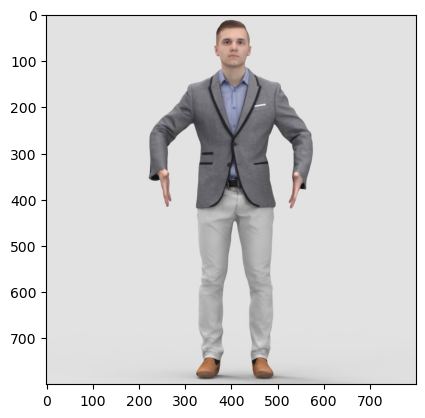

In [21]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv2.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), 
    swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv2.minMaxLoc(heatMap)
        #heatmap은 최대값 위치를 찾아서 point에, 최대값 자체는 conf에 저장한다. 최소값은 안쓰니 밑줄 !, point는 46 by 46 에서의 위치인데, 입력영상에서의 위치를 찾는 것이니,!! 여기서 전체 w h에서의 위치를 비례식으로 찾는다.
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv2.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv2.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
    
    t, _ = net.getPerfProfile()
    freq = cv2.getTickFrequency() / 1000
    cv2.putText(frame, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame

In [23]:
estimated_image = pose_estimation(img)

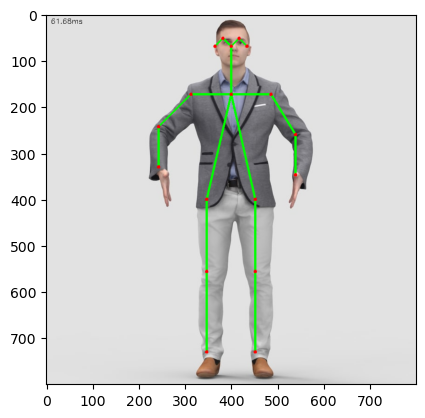

In [25]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()